In [6]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import pandas as pd  
from matplotlib import pyplot as plt

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import seaborn as sns

import numpy as np

In [7]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')

In [9]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

list_ = sorted(list_, key=lambda x: x['size'], reverse=True)
df = ds[ds['package_name'] == list_[0]['package_name']]
corpus = list(df['review'])

ds_new = pd.DataFrame(corpus)
print(ds_new)

                                                      0
0                                        ooh. m.g hffjn
1                                   Wire strippers Tool
2                                                  Done
3                                  For an older version
4                             GPS NOT LOCTOIN HELP PLES
...                                                 ...
103530                                             Nice
103531                                           F WORD
103532  Why I need this app for another app to access.?
103533                                    Very nice app
103534                                               No

[103535 rows x 1 columns]


In [10]:
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
#corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
#cosine_scores = util.cos_sim(corpus_embeddings, corpus_embeddings)

In [11]:
score = []
for k in range(1, 11):
    clustering_model = KMeans(n_clusters=k)
    clustering_model.fit(corpus_embeddings)
    score.append(clustering_model.inertia_)

In [12]:
best_kmeans = 0
best_score = 10000000
for i in range(len(score)):
    if(score[i] < best_score):
        best_score = score[i]
        best_kmeans = i+1
print("best score: ", best_score)
print("best k: ", best_kmeans)

best score:  65167.321890729014
best k:  10


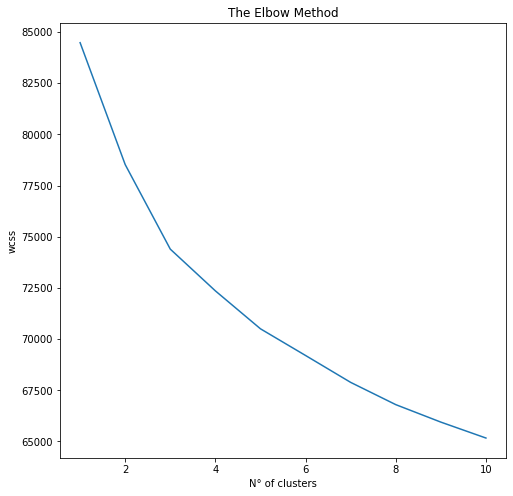

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('N° of clusters')
plt.ylabel('wcss')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.079304285
[1 1 1 ... 0 0 1]
For n_clusters = 3 The average silhouette_score is : 0.06733828
[2 2 2 ... 1 1 2]
For n_clusters = 4 The average silhouette_score is : 0.06376348
[0 0 0 ... 2 2 0]
For n_clusters = 5 The average silhouette_score is : 0.05825669
[0 0 0 ... 4 4 0]
For n_clusters = 6 The average silhouette_score is : 0.05524001
[5 1 1 ... 0 0 1]
For n_clusters = 7 The average silhouette_score is : 0.063997194
[1 1 1 ... 3 3 1]
For n_clusters = 8 The average silhouette_score is : 0.0681517
[6 6 6 ... 2 2 6]
For n_clusters = 9 The average silhouette_score is : 0.07490796
[6 6 6 ... 3 3 6]
For n_clusters = 10 The average silhouette_score is : 0.07822658
[4 4 4 ... 2 2 4]


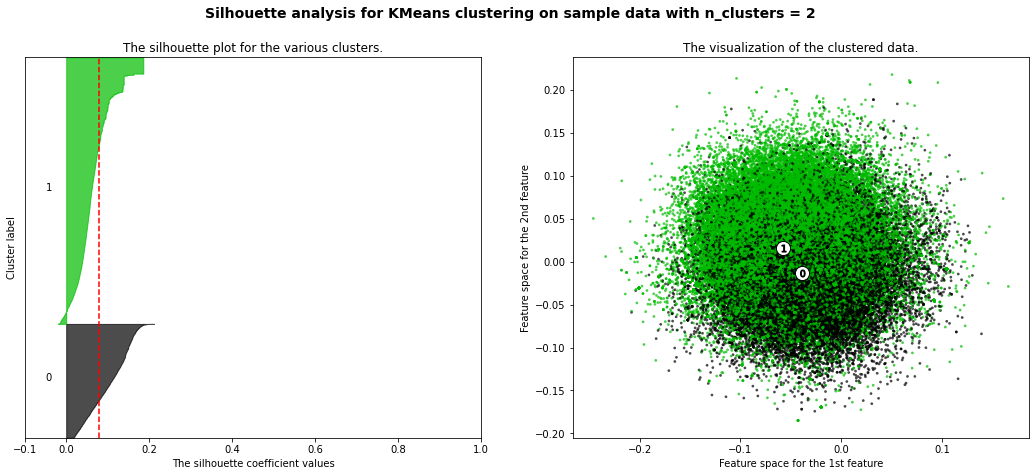

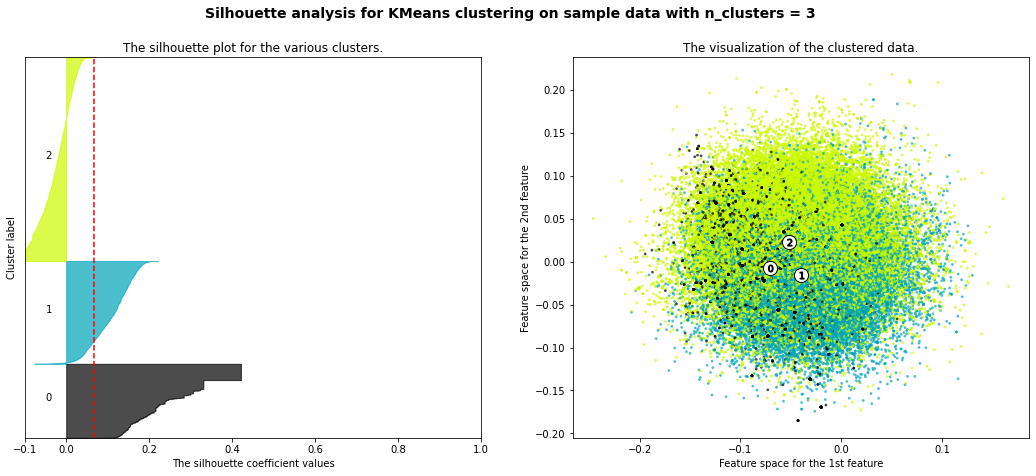

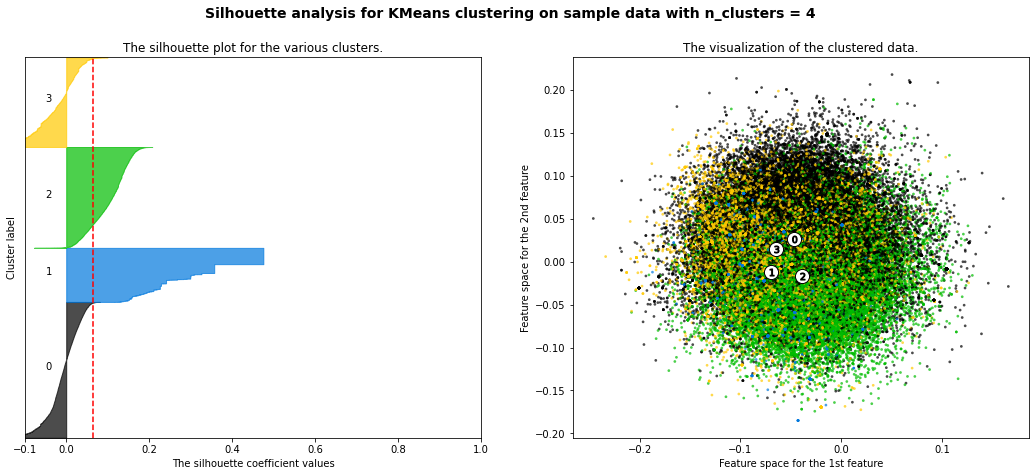

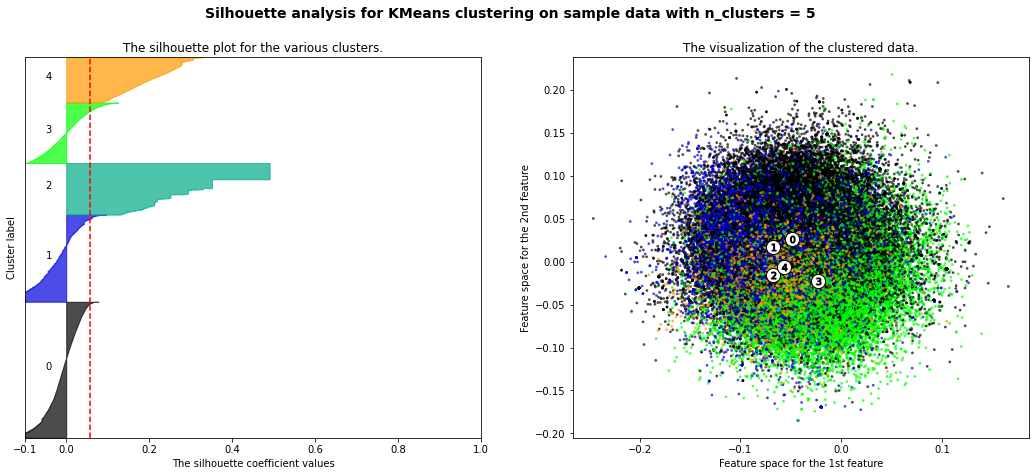

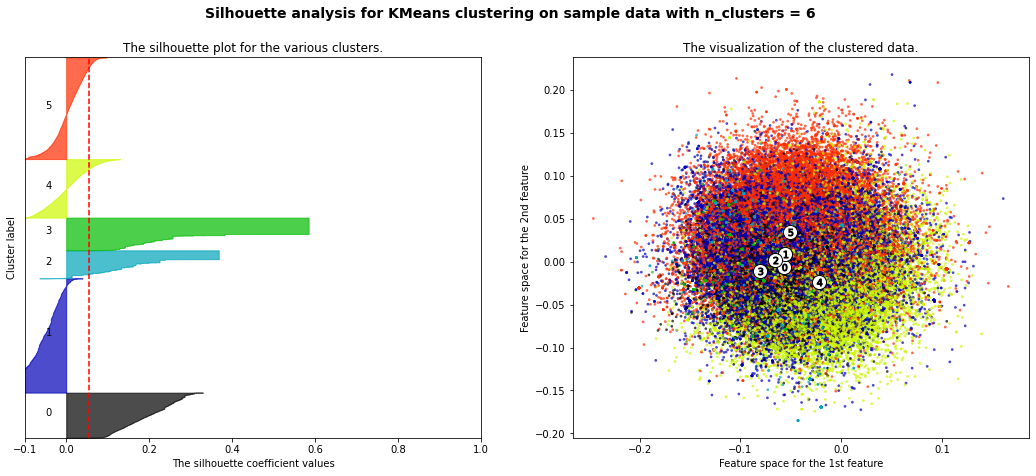

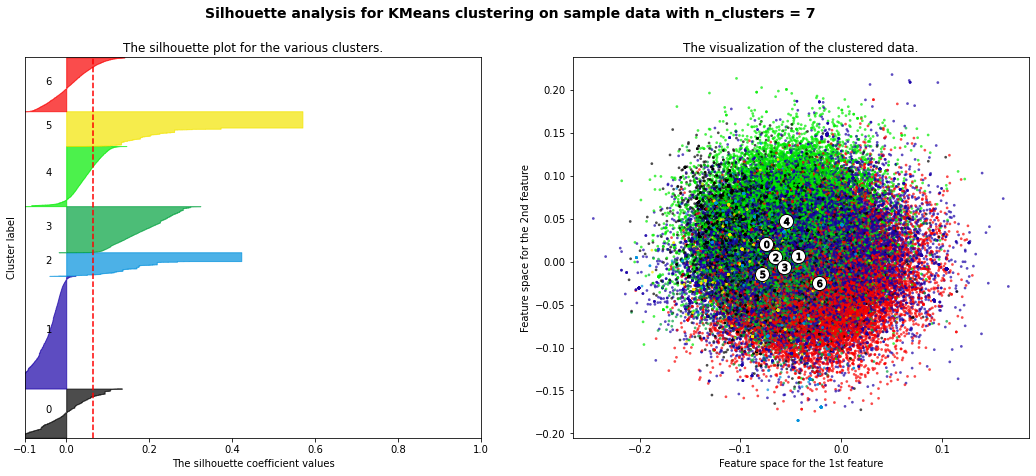

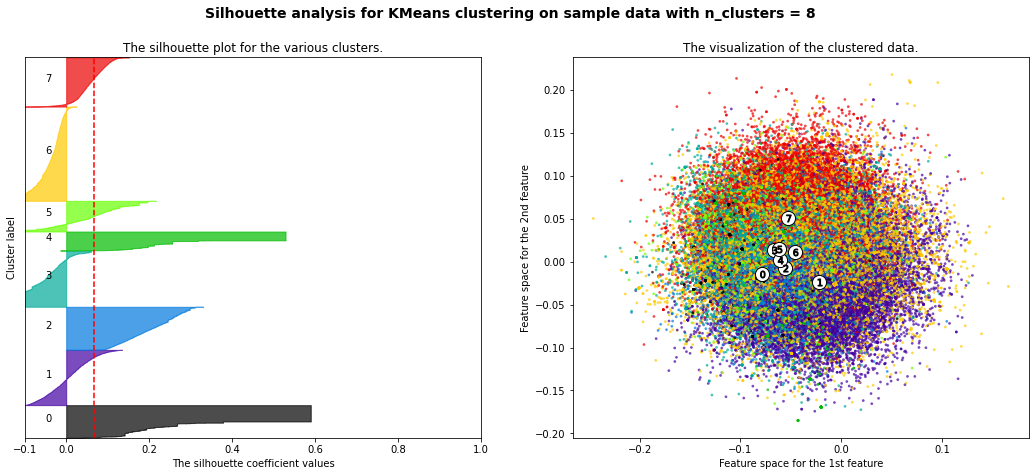

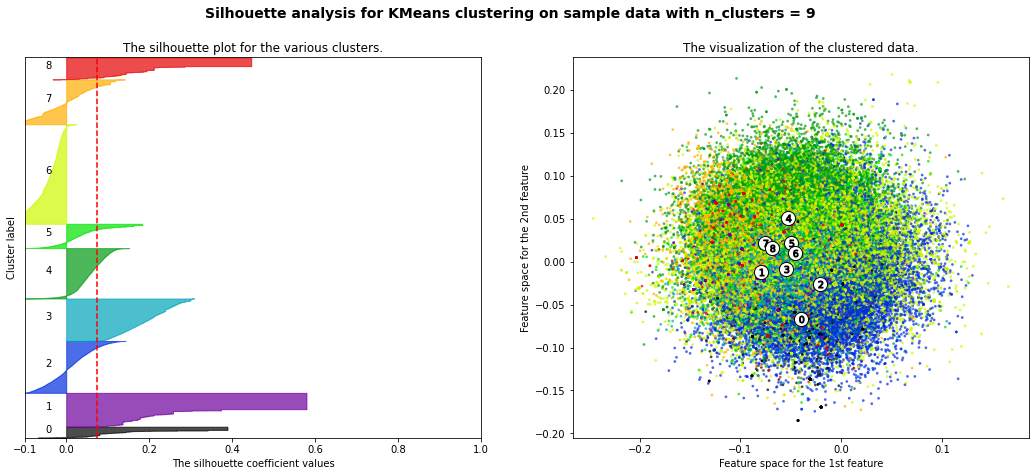

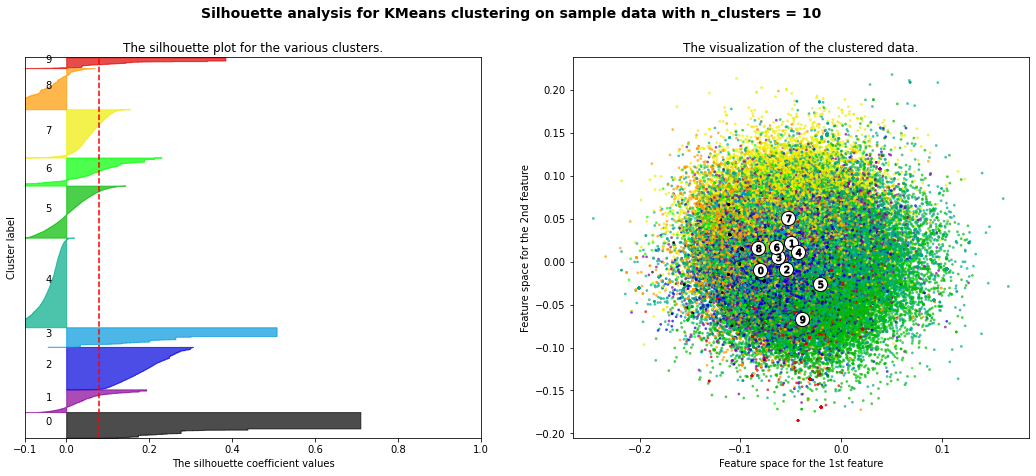

best avg:  0.079304285
best k:  2


In [14]:
average_best = 0
best_k = 0
for k in range(2,11):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(corpus_embeddings) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, init="k-means++", random_state=10)
    cluster_labels = clusterer.fit_predict(corpus_embeddings)

    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    if(silhouette_avg > average_best): 
        average_best = silhouette_avg
        best_k = k
        ds_new['clusters'] = cluster_labels
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    print(cluster_labels)

    #print(cluster_labels)

    sample_silhouette_values = silhouette_samples(corpus_embeddings, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(corpus_embeddings[:, 0], corpus_embeddings[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')      

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()
print("best avg: ", average_best)
print("best k: ", best_k)

In [15]:
ds_new

,0,clusters
0,ooh. m.g hffjn,1
1,Wire strippers Tool,1
2,Done,1
3,For an older version,0
4,GPS NOT LOCTOIN HELP PLES,0
...,...,...
103530,Nice,1
103531,F WORD,1
103532,Why I need this app for another app to access.?,0
103533,Very nice app,0


In [26]:
ds_new['clusters'] = ['cluster_' + str(cluster) for cluster in ds_new['clusters']]
ds_new.sort_values(by = ['clusters'])

,0,clusters
61237,Good Googleplay,cluster_cluster_cluster_0
48800,Ahhhhh It is OK because I have to update a lot.,cluster_cluster_cluster_0
48801,It's slow It's taking for long,cluster_cluster_cluster_0
48803,works fine with updated version. Love it.,cluster_cluster_cluster_0
86078,It does not update. There is no problem with m...,cluster_cluster_cluster_0
...,...,...
41283,Digicel Top up balance,cluster_cluster_cluster_1
41282,Yogesh Speed,cluster_cluster_cluster_1
41279,Bagus,cluster_cluster_cluster_1
41277,Good aap,cluster_cluster_cluster_1
